# 1. Introduction

This is the week 3 project for DTSA-5511 Introduction to Deep Learning. The purpose of this project is to develop a CNN to identify metastatic cancer in small images taken from larger digital scans. This is a binary classification problem where the image center is either positive or negative for tumor tissue. 

Dataset

The data set consists of microscopic images of lymph node tissue. The images are 96x96 pixels but only the 32x32 center region of the image is being classified. There are around 220,000 labeled images for training and another 57,000 used for the competition test set. The image labels are provided in a seperate csv file.

In [14]:
# Import required libraries
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os
from tqdm import notebook,trange
import tqdm
import matplotlib.pyplot as plt
import altair as alt
import cv2
import gc
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
# Import data set
# since this is a large amount of data we will create a dataframe of the paths to each image and match up to the labels.
# set base directory this can be updated when run locally
path = '/kaggle/input/histopathologic-cancer-detection/'

# set test and train directory
train_path = path + 'train/'
test_path = path + 'test/'

# read labels
labels = pd.read_csv(path + 'train_labels.csv')

# df of image paths
df = pd.DataFrame({'path' : glob(os.path.join(train_path, '*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[5].split(".")[0])
# merge labels with image paths
df = df.merge(labels, on = "id")

df.head(3)

,path,id,label
0,/kaggle/input/histopathologic-cancer-detection...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,/kaggle/input/histopathologic-cancer-detection...,092d0eedebce504847715ee046b6ad74b57599b4,0
2,/kaggle/input/histopathologic-cancer-detection...,b0d2582c6218a8764323fc940b41312282b99bf4,0


In [12]:
# Function to load a set number of images
# function takes in 'n' number of images in batch and 
# 'df' dataframe with file paths and square image size in 'p' pixels.

def batch_me(n, df, p = 96):
    # generate array for images 
    images = np.zeros([n,p,p,3], dtype = np.uint8)
    # pull labels from df
    labels = np.squeeze(df['label'].to_numpy())[0:n]
    # read in images tqdm.notebook.tqdm
    for i, row in tqdm.notebook.tqdm(df.iterrows(), total=n):
        if i == n:
            break
        images[i] = cv2.imread(row['path'])
    
    return images,labels


In [9]:
# create batch of first 1000 images
n=1000
X,y = batch_me(n,df)

NameError: name 'tqdm' is not defined

# 2. EDA
Now we will perform some exploratory data analysis. We will look a few of the pictures to see what we are working with. We will also look at the distribution of the two labels. And last we will look at the color histograms of each group of pictures. 


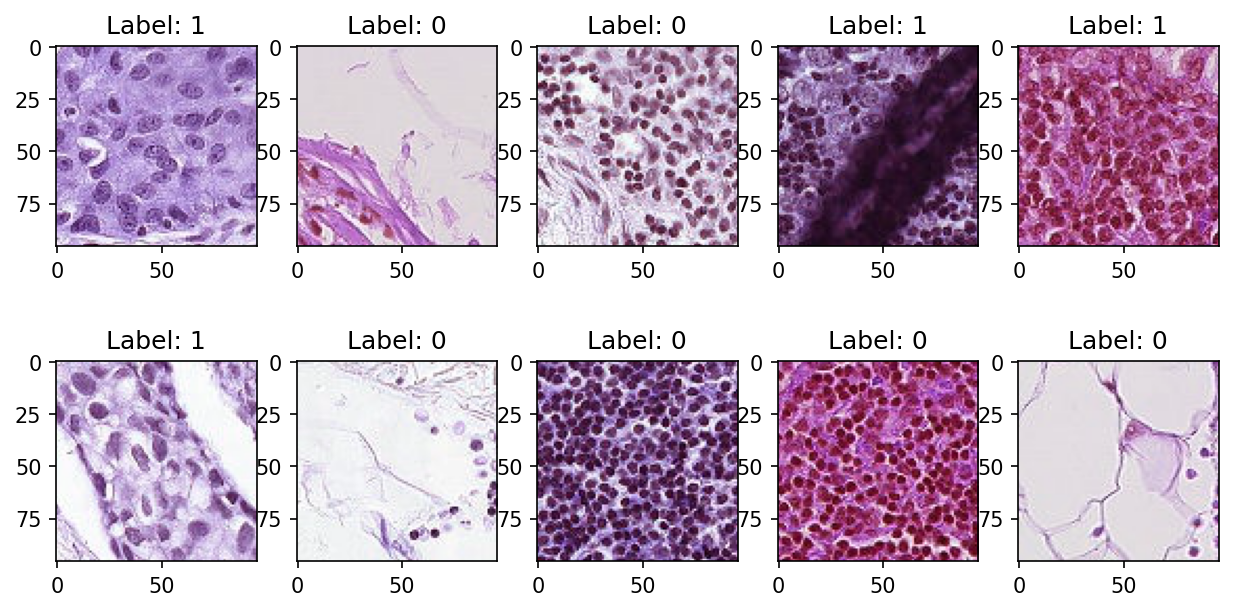

In [9]:
# display first 10 pictures with label 
fig = plt.figure(figsize=(10, 5), dpi=150)

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    plt.imshow(X[i])
    ax.set_title('Label: ' + str(y[i]))

Looking at the images it is not immediatly clear what makes an image positive or negative for cancer. If even humans need to be trained to detect signs of cancer this should be a good dataset for a CNN.   

In [10]:
# plot the frequency of positive and negative labels
# only looking at first 5000 due to constraints of altair package
sub_label = df.head(5000)

alt.Chart(sub_label).mark_bar().encode(
    alt.X("label:Q", bin = alt.BinParams(maxbins = 2)),
    y='count()',)


alt.Chart(...)

Looking at the split we have a a roughly 60/40 split of our labels. This tells us that even a dumb classifier that gives everything the same label can be 60% accurate. 

Next lets look at the average color profile of each group of images. This might show us some differences between positive and negative labels. 

In [11]:
# lets first define a function to get average histograms

def avg_hist(df, bins=(8,8,8)):
    hist_red = []
    hist_green = []
    hist_blue = []
    
    for image in df:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
         # Calculate histogram
        hist1 = cv2.calcHist([image], [0], None, [64], [0, 256])
        hist1 = cv2.normalize(hist1, hist1).flatten()
        hist_red.append(hist1)
        hist2 = cv2.calcHist([image], [1], None, [64], [0, 256])
        hist2 = cv2.normalize(hist2, hist2).flatten()
        hist_green.append(hist2)
        hist3 = cv2.calcHist([image], [2], None, [64], [0, 256])
        hist3 = cv2.normalize(hist3, hist3).flatten()
        hist_blue.append(hist3)
        
    red = np.sum(hist_red, axis=0)
    green = np.sum(hist_green, axis=0)
    blue = np.sum(hist_blue, axis=0)

    return red, green, blue

In [12]:
# get the first 1000 images and split into positive and negative labels

# create batch of first 1000 images
n=1000
X,y = batch_me(n,df)


In [13]:
# split images

pos_split = X[y == 1.00]
neg_split = X[y == 0.00]

pos_r, pos_g, pos_b = avg_hist(pos_split)
neg_r, neg_g, neg_b = avg_hist(neg_split)

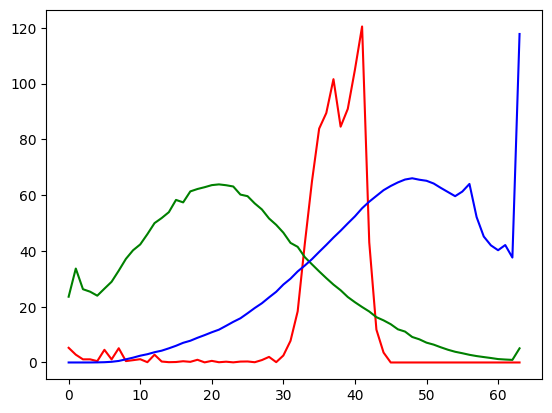

In [14]:
plt.plot(pos_r, color = 'red')
plt.plot(pos_g, color = 'green')
plt.plot(pos_b, color = 'blue')

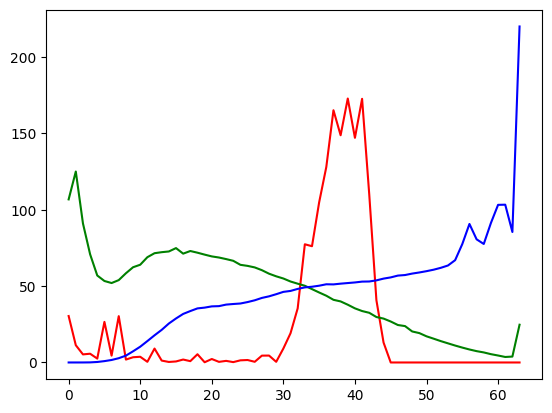

In [15]:
plt.plot(neg_r, color = 'red')
plt.plot(neg_g, color = 'green')
plt.plot(neg_b, color = 'blue')

We do see some structural differences in the color histograms between positive and negative cancer pictures. This may prove useful when developing the model.

# 3. Model

Now we will start to develop our CNN model using Keras. I initially ran a small batch of 25000 pictures to verify my code followed by training on the complete data set. I initially was going to split and run a test and train dataset but with kaggle there is already a test set and you can see the results when submitted. 

For building the model I started with setting initial parameters followed by building 3 layers of filters and then a dense layer. The final output uses sigmiod function since this is a binary classification problem. 

To compile and train the model I set batch size to 128 and learning rate to .005. After starting a couple training cycles I settled on these figures to save time.

I kept running into memory issues and the notebook was crashing above 22 epochs so I limited epochs to 20. 

In [15]:
# test batch of 25k to verify model code
#n=25000 
# Load complete dataset for final Model
n = df["path"].size 
X,y = batch_me(n=n,df=df)


  0%|          | 0/220025 [00:00<?, ?it/s]

In [19]:
# split data into test and train
ratio = 1 # using complete dataset for training
split = int(np.round(ratio * y.shape[0]))

idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

In [20]:
#Collect garbage to save memory
positives_samples = None
negative_samples = None
gc.collect();

In [21]:
# parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()

In [23]:
# Layer 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

In [24]:
# Layer 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

In [25]:
# Layer 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

In [26]:
# Final Dense Layer
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

In [27]:
# Output Layer
model.add(Dense(1, activation = "sigmoid"))

In [32]:
# Compile Model

batch = 128
rate = .005

model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(rate), 
              metrics=[keras.metrics.BinaryAccuracy(name="acc")])

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),]

In [34]:
# Train
#epoch = 5
epoch = 20
model.fit(
    x = X,
    y = y,
    epochs=epoch,
    callbacks=callbacks,
    batch_size = batch,
)


Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 134s 72ms/step - acc: 0.9295 - loss: 0.1855
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - acc: 0.9328 - loss: 0.1759
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - acc: 0.9371 - loss: 0.1689
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - acc: 0.9391 - loss: 0.1626
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - acc: 0.9421 - loss: 0.1557
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - acc: 0.9440 - loss: 0.1516
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9443 - loss: 0.1496
Epoch 8/20
1122/1719 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - acc: 0.9461 - loss: 0.1458

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9491 - loss: 0.1394
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9476 - loss: 0.1413
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9488 - loss: 0.1390
Epoch 12/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - acc: 0.9502 - loss: 0.1337
Epoch 13/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9507 - loss: 0.1345
Epoch 14/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 66ms/step - acc: 0.9513 - loss: 0.1327
Epoch 15/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 66ms/step - acc: 0.9527 - loss: 0.1282
Epoch 16/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9546 - loss: 0.1253
Epoch 17/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 66ms/step - acc: 0.9537 - loss: 0.1257
Epoch 18/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9532 - loss: 0.1265
Epoch 19/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/step - acc: 0.9555 - loss: 0.1229
Epoch 20/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 67ms/st

# 4. Results/Analysis

For initial results the model achieved a area under the curve of .880. With further tuning I am confident this could be greatly increased. THe final score of the submitted test data was .7596. 

In [35]:
# make a prediction
y_pred = model.predict(X)

6876/6876 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


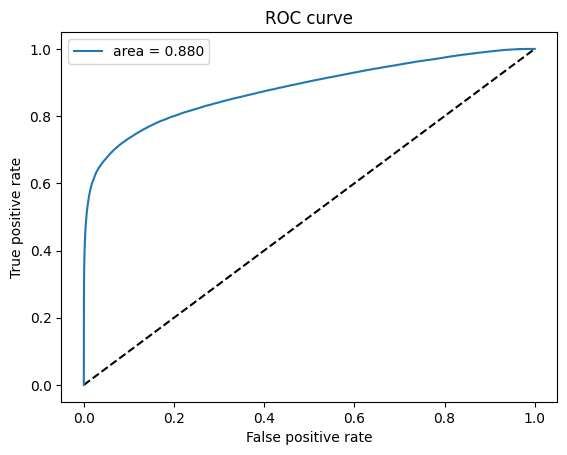

In [37]:
fpr, tpr, thresholds = roc_curve(y, y_pred)
auc_train = auc(fpr, tpr)

# Plot ROC Curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_train))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [38]:
# Create Kaggle Submission
X = None
y = None
gc.collect();

df_test = pd.DataFrame({'path' : glob(os.path.join(test_path, '*.tif'))})
df_test['id'] = df_test.path.map(lambda x: x.split('/')[5].split(".")[0])

# Load complete Test dataset 
p = 96
n = df_test["path"].size 
test_images = np.zeros([n,p,p,3], dtype = np.uint8)

    # read in images tqdm.notebook.tqdm
for i, row in tqdm.notebook.tqdm(df_test.iterrows(), total=n):
    if i == n:
        break
    test_images[i] = cv2.imread(row['path'])

  0%|          | 0/57458 [00:00<?, ?it/s]

In [39]:
# create predictions
predictions = model.predict(test_images)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


In [41]:
# Generate submission
df_test['label'] = predictions
df_test.head()
submission = df_test[["id", "label"]].copy()
submission['label'] = submission['label'].map(lambda x: 1 if x > 0.5 else 0)
submission.head()
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

# 5. Conclusion

In conclusion we set out to design, train, and test a CNN model to detect cancer in microscopic tumor pictures. First we imported the dataset and looked at some different characteristics of the data. After performing EDA we set up a basic CNN model to train on the data set. We then evaluated the model and performed predictions on the test set. 

I feel the submitted score of .7596 is a decent first try. With further fine tuning of the parameters and model architecture a much better score could be achieved. The main limitation on building this model was being limited to the kaggle notebook environment. I did run into memory issues and lengthy training times. 